# Table of contents
* [Word Tokenization](#word-tokenization)
    * [Most Common Words](#most-common-words)
    * [Feature Creation](#most-common-words-feature-creation)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Import the tweets dataset, this is a cut down version of the full tweet 
# dataset per the operations performed in the file "eda-rea-v-liv-2018"
en_tweets_df = pd.read_csv('en_tweets_df.csv', lineterminator='\n')

In [14]:
# As this dataset is generated from earlier work it carries its prior index, the below changes the column name
en_tweets_df.rename(columns={'Unnamed: 0':'original_df_index'}, inplace=True)

In [3]:
# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/jamie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jamie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Word Tokenization <a class="anchor" id="word-tokenization"></a>

In [4]:
# Create a function that returns clean tokenized words for a tweet
english_stopwords = stopwords.words('english')

# Context specific stop words (refer "most common words" section below for identification approach
# rt = short for retweet, this does not provide any insights and a column already exists to identify retweets
# http & https = the start of web links these provide little value as "words", future work: these could be
# to build a feature along thelines of "Contains Web Link?"
# uclfinal, championsleague, championsleaguefinal = "hashtag"/topical words, given the original tweet dataset
# contained only tweets that had a hashtag of uclfinal these words do not add value to the analysis
custom_stopwords = ['rt', 'http', 'https', 'uclfinal', 'championsleague', 'championsleaguefinal']

# Combine the two stop words lists
stop_words = english_stopwords + custom_stopwords

def CleanTokenizedWords(tweet):
    word_tokenized = word_tokenize(tweet)

    # lowercasing
    cleaned_word_tokenized = [word.lower().strip() for word in word_tokenized]
    
    # replacing some unwanted things
    cleaned_word_tokenized = [word.replace('(','').replace(')','') for word in cleaned_word_tokenized if word.isalpha()]
    
    # removing stopwords
    cleaned_word_tokenized = [word for word in cleaned_word_tokenized if word not in stop_words]
    
    return cleaned_word_tokenized

In [5]:
# Tokenize words in tweets
en_tweets_df['tokenized_words'] = en_tweets_df.apply(lambda row: CleanTokenizedWords(row['tweet_text']), axis=1)

### Most Common Words <a class="anchor" id="most-common-words"></a>

In [6]:
# There are three key benefits to finding the most common words:
    # 1. Further refinements could be made to CleanTokenizedWords in terms of words to exclude
    # 2. We can obtain further insights into the data
    # 3. Can select key words that could be used to generate features    

# Convert tokenized words column into a single list of words
words_list = en_tweets_df['tokenized_words'].values.tolist()

# Flatten the list
flattened_words_list = [j for sub in words_list for j in sub]

# Find the most common words
fdist = FreqDist(x.lower() for x in flattened_words_list)
fdist.most_common(100)

[('salah', 37563),
 ('ramos', 31930),
 ('liverpool', 30926),
 ('bale', 22289),
 ('madrid', 22036),
 ('real', 20639),
 ('lfc', 16149),
 ('goal', 16090),
 ('sergio', 14423),
 ('gareth', 11287),
 ('final', 9889),
 ('world', 8590),
 ('mo', 8545),
 ('karius', 8490),
 ('one', 7878),
 ('ronaldo', 7447),
 ('cup', 7327),
 ('shoulder', 7185),
 ('like', 6794),
 ('game', 6668),
 ('ever', 6384),
 ('realmadrid', 6346),
 ('league', 5829),
 ('best', 5723),
 ('champions', 5498),
 ('time', 5319),
 ('vs', 5227),
 ('tears', 5223),
 ('goals', 5080),
 ('see', 4987),
 ('zidane', 4929),
 ('live', 4838),
 ('season', 4769),
 ('way', 4618),
 ('mosalah', 4550),
 ('win', 4528),
 ('fans', 4456),
 ('retweet', 4383),
 ('get', 4317),
 ('sad', 4317),
 ('football', 4277),
 ('first', 4274),
 ('watch', 4270),
 ('miss', 4102),
 ('go', 4021),
 ('rmaliv', 3931),
 ('dislocated', 3823),
 ('cristiano', 3778),
 ('injury', 3778),
 ('halamadrid', 3765),
 ('mane', 3740),
 ('mohamed', 3733),
 ('reds', 3675),
 ('ucl', 3668),
 ('bbc',

### Feature Creation  <a class="anchor" id="most-common-words-feature-creation"></a>

In [7]:
# The following functions are used to create a feature column for the most common words
def WordFrequency(tokenized_words, word):
    return tokenized_words.count(word)
    

def FeatureCreation(list_of_words):
    for word in list_of_words:
        en_tweets_df['FT_' + word + '_frequency'] = en_tweets_df.apply(lambda row: WordFrequency(row['tokenized_words'], word), axis=1)

In [8]:
# Create features for the top 50 words
FeatureCreation([i[0] for i in fdist.most_common(50)])

### Correlation

In [59]:
# Define a list of feature columns to include in correlation
cols = [col for col in en_tweets_df.columns if col[:3] == 'FT_']

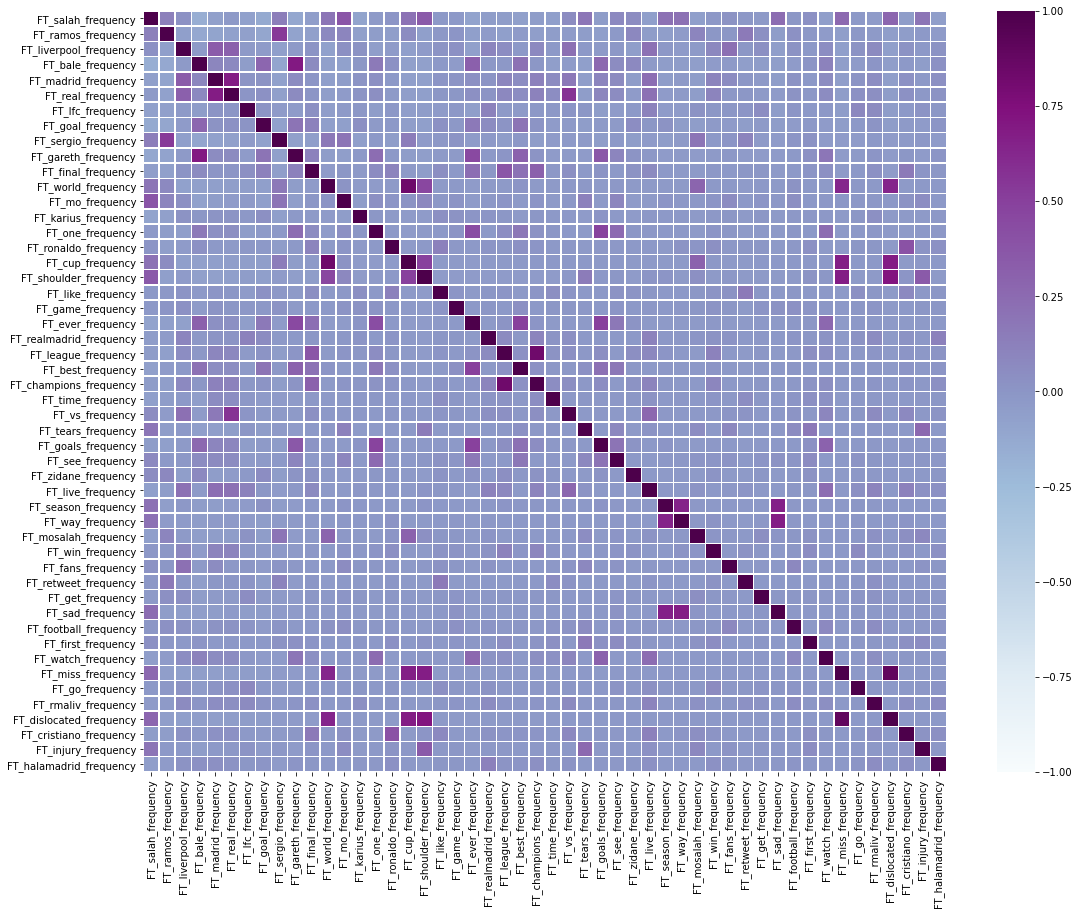

In [60]:
plt.figure(figsize=(18,14))
sns.heatmap(en_tweets_df[cols].corr(),
            vmin=-1,
            vmax=1,
            center=0,
            cmap="BuPu",
            linewidths=.5,
            xticklabels=True,
            yticklabels=True);

### Models <a class="anchor" id="most-common-words-models"></a>

#### KMeans <a class="anchor" id="most-common-words-kmeans"></a>

In [41]:
import sklearn
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report

In [42]:
from mpl_toolkits.mplot3d import Axes3D

In [77]:
# There are five clusters that I would like to try and identify
# 1) Liverpool Positive 2) Liverpool Negative 3) Madrid Positive 4) Madrid Negative 5) Neutral
k = 5
X = en_tweets_df[cols]

kmeans = KMeans(n_clusters=k, random_state=8)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

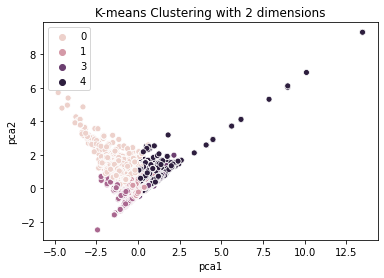

In [94]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(X)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=y_kmeans, data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# Useful snippets etc.

In [50]:
###############################################################
# Memory usage https://stackoverflow.com/questions/16261240/releasing-memory-of-huge-numpy-array-in-ipython/16278056
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                  en_tweets_df:  2.0 GiB
          flattened_words_list: 10.5 MiB
                    words_list:  1.4 MiB
                         fdist:  1.3 MiB
                            _9: 136.1 KiB
                           _11: 38.4 KiB
                           _12: 38.4 KiB
                           _13: 38.4 KiB
                           _15: 38.4 KiB
                           _17: 38.3 KiB
